In [90]:
from astropy import units as u
from astropy.io import fits
from hiresprv.auth import login
from hiresprv.idldriver import Idldriver
from hiresprv.database import Database
from hiresprv.download import Download
from PyAstronomy import pyasl
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D
from scipy import interpolate 
from alpha_shapes import * 

import numpy as np
import pandas as pd 

class CIR:

    def __init__(self,star_ID_array,wl_solution_path = './wl_solution.csv',
                 rvOutputPath='./RVOutput',spectraOutputPath = './SpectraOutput' ):
        '''
        Used for reducing HIRES data to get it ready for being fed into The Cannon. 

        star_ID_array: is an array that contains strings of the HIRES ID for stars
        wl_solution_path: defaulted to ./wl_solution.csv, the file at the end of your given path
                          needs to have the first 2 rows not contain data. skip_header is set to 2
        rvOutputPath: defaulted to ./RVOutput, the folder at the end of your path needs to have already
                      been created before you initalize this class
        spectraOutputPath: defaulted to ./SpectraOutput, the folder at the end of your path needs to have 
                            already been created before you initalize this class
        '''

        login('prv.cookies')                                               # For logging into the NExSci servers 
        self.idldriver = Idldriver('prv.cookies')                          # For creating RV scripts 
        self.state = Database('prv.cookies')                               # For retrieving data from HIRES 
        self.dataRV = Download('prv.cookies', rvOutputPath)                # For downloading RV
        self.dataSpectra = Download('prv.cookies',spectraOutputPath)       # For downloading Spectra 
        self.star_ID_array = star_ID_array                                 # HIRES ID 
        self.wl_solution = np.genfromtxt(wl_solution_path,skip_header=2)   # UNITS: Angstrom
        self.Ivar = {}                                                     # For storing sigma valeus 
        self.filename_rv_df = pd.DataFrame()                               # For storing meta Data
        
    
    def Run(self,use_data=False,slow_normalize = False ):
        '''
        Description: This method will run all of the following
            Unless parameter is set to True
             Find_and_download_all_rv_obs -> 
             DownloadSpectra ->
             Continuum Normalize ->
             CrossCorrelate -> 
             Interpolate 
        '''
        if not use_data:
            self.Find_and_download_all_rv_obs()
            self.DownloadSpectra()
        else:
            self.NoDownload()
        if not slow_normalize:
            self.ContinuumNormalize()
        else:
            self.AlphaNormalization()
        self.CrossCorrelate()
        self.Interpolate()


    def Find_and_download_all_rv_obs(self):
        '''            
        Description: This method downloads the rotational velocity metadata and
        returns a dictionary that makes it easy to identify what stars' rotational 
        velocities nearest 0 as well as the filenames for which they came from.

        Note: The dataframe produced by this method will remove all the stars that did 
              not have any RV data produced by rvcurve. This does not mean that 
              the star doesn't have any RV data. It could mean a few things, the ID
              is wrong, contains a character that isn't currently supported by the 
              HIRES pipeline, it could have too few RV observations to make an 
              RV curve, etc...
        '''
        print("Downloading RV Data Has Began")
        #Downloading the RV data as well as getting the largest RV value for each star
        hiresName_fileName_rv_dic = {"HIRESName": [],"FILENAME":[], "RV":[]}  
        rvDownloadLocation = self.dataRV.localdir
        for name in self.star_ID_array:
            #Make sure the data is in workspace
            hiresName_fileName_rv_dic["HIRESName"].append(name)
            try:
                rtn = self.dataRV.rvcurve(name)
                nameLoc = '{0}/vst{1}.csv'.format(rvDownloadLocation,name)
                temp_df = pd.read_csv(nameLoc)
                if not temp_df.empty:
                    rv_temp = abs(temp_df['RV'])
                    row = temp_df[temp_df['RV'] == rv_temp.max()]
                    if row.empty: #The absolute max rv is negative 
                        row = temp_df[temp_df['RV'] == -rv_temp.max()]
                    hiresName_fileName_rv_dic["RV"] += [row["RV"].to_numpy()[0]]
                    hiresName_fileName_rv_dic["FILENAME"] += [row["FILENAME"].to_numpy()[0]]
                else:
                    #This is for removing these RV-less stars 
                    hiresName_fileName_rv_dic["RV"] += [pd.NA]
                    hiresName_fileName_rv_dic["FILENAME"] += [pd.NA]
            except OSError: #This error occurs because for some reason the star's rvcurve wasn't created
                    #This is for removing these stars that have no RV metadata  
                    hiresName_fileName_rv_dic["RV"] += [pd.NA]
                    hiresName_fileName_rv_dic["FILENAME"] += [pd.NA]
        df = pd.DataFrame(hiresName_fileName_rv_dic) 
        self.filename_rv_df = df.dropna() #If you don't drop the na's then other methods will break
        self.filename_rv_df.to_csv("HIRES_Filename_rv.csv",index_label=False,index=False)
        print("Downloading RV Data Has Ended")
        

    def DownloadSpectra(self):
        '''
        Description: This method downloads all the deblazed spectra from HIRES that are in
                     self.filename_rv_df["FILENAME"] to self.dataSpectra.localdir
        '''
        print("Downloading Spectra Has Began")
        self.spectraDic = {} 
        download_Location = self.dataSpectra.localdir #This is the second parameter of hiresprv.download.Download
        for filename in self.filename_rv_df["FILENAME"]:
            #I tried to use the , seperation and new line seperation 
            #for the different file names but it doesn't seem to work.
            #Thus, a for-loop was used!
            self.dataSpectra.spectrum(filename.replace("r",""))  #Download spectra 
            file_path = "{0}/{1}.fits".format(download_Location,filename)
            temp_deblazedFlux = fits.getdata(file_path)
            temp_deblazedFlux = temp_deblazedFlux.flatten()
            #spectraDic is the deblazed spectra 
            if not np.isnan(temp_deblazedFlux).any(): #Happens in the ivar
                self.spectraDic[filename] = temp_deblazedFlux
                self.SigmaCalculation(filename) #To get the sigma for Inverse variance 
            else:
                print(f"****{filename} HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES")   
        print("Downloading Spectra Has Ended")

    def ContinuumNormalize(self):
        '''        
        Description: This method uses specutils' Spectrum1D function to fit a function
                     to each echelle order spectra then subtracts the function from the 
                     echelle order. 
                     The normalized spectra are put in the {} called self.spectraDic with
                     the keys being the HIRES filename and the values being a continuum 
                     normalized 1-D array.   
        '''
        #This is the same for all HIRES data 
        print("Continuum Normalization Began")
    
        spectral_axis_wl_solution = self.wl_solution*u.um
        length = len(spectral_axis_wl_solution)
        download_Location = self.dataSpectra.localdir 
        #Continumm Normalize
        for filename in self.spectraDic:
            deblazedFlux = self.spectraDic[filename]*u.Jy
            ivarSigma = self.Ivar[filename]*u.Jy
            normalized_array = np.array([])
            ivar_array = np.array([])
            
            for j in range(0,16): #Normalize each individual echelle order 
                i  = 4021 * j #Each HIRES echelle order has 4021 elements 
                temp_echelle_wl,temp_echelle_flux = spectral_axis_wl_solution[i:i+4021],deblazedFlux[i:i+4021]
                temp_sigma  =  ivarSigma[i:i+4021]
                
                #Use specutils' Spectrum1D to fit continuum normalize the echelle order
                #referencing https://specutils.readthedocs.io/en/stable/spectrum1d.html
                spectrum = Spectrum1D(flux=temp_echelle_flux, spectral_axis=temp_echelle_wl)
                g1_fit = fit_generic_continuum(spectrum)
                flux_fit = g1_fit(temp_echelle_wl)
                
                #Subracting the continuum from the echelle order & 
                #the section of sigma corresponding to the current echelle order
                normalized_echelle = temp_echelle_flux / flux_fit
                normalized_ivar = temp_sigma / flux_fit
                #Converting to a float like this removes 2 decimal places from normalized_echelle
                normalized_echelle = np.array(list(map(np.float,normalized_echelle))) 
                normalized_ivar = np.array(list(map(np.float,normalized_ivar))) 
                #Make all the echelle spectra into a 1-D array again
                normalized_array = np.append(normalized_array,normalized_echelle)
                ivar_array = np.append(ivar_array,normalized_ivar)
            spec_norm_scaled = normalized_array/np.repeat(np.percentile(normalized_array, 95, axis=0)[np.newaxis], length, axis=0)
            self.spectraDic[filename] = spec_norm_scaled #1D normalized spectra (all 16 echelle orders)
            self.Ivar[filename] = ivar_array #Technically this isn't the inverse variacne yet
        print("Continuum Normalization Ended")
            
    def CrossCorrelate(self,numOfEdgesToSkip = 100):
        '''
        Description: Uses Pyastronomy's crosscorrRV function to compute the cross correlation.

                     The updated spectra are put into self.spectraDic.   

        numOfEdgesToSkip: the amount of pixels to cut off both ends of the spectra.
        '''
        print("Cross Correlate Has Began")
        wl_solution = np.genfromtxt('./wl_solution.csv',skip_header=2) #UNITS: Angstrom
        wvlen,c = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,usecols=(1,4),unpack=True) 
        wvlen, c = wvlen[::-1], c[::-1]
        
        solar_echelle_list = []
        for echelle_num in range(16):
            begin,end = 4021*echelle_num, 4021*(echelle_num+1)
            temp_echelle_wv = wl_solution[begin:end]
            temp_lower_bound = wvlen >= temp_echelle_wv[0]
            temp_upper_bound = wvlen[temp_lower_bound] <= temp_echelle_wv[-1]
            temp_wv = wvlen[temp_lower_bound][temp_upper_bound]
            temp_c = c[temp_lower_bound][temp_upper_bound]
            solar_echelle_list.append((temp_wv,temp_c))
        
        
        wl_solution = np.genfromtxt('./wl_solution.csv',skip_header=2) #UNITS: Angstrom
        RV = 80 #60 gave good results 
        crossCorrelatedspectra = {} #Key: FILENAME Values: (correlated wavelength, normalized flux)
        for i in range(self.filename_rv_df.shape[0]):
            row = self.filename_rv_df.iloc[i]
            filename = row[1]
            normalizedFlux = self.spectraDic[filename]
            
            z_list = [] #Going to take the average of all the echelle shifts 
            for echelle_num in range(2,3): #DELETE WHEN DONE
#             for echelle_num in range(16):
                begin,end = 4021*echelle_num, 4021*(echelle_num+1)
                e_wv = wl_solution[begin:end]  #hires 
                e_flux = normalizedFlux[begin:end]
                s_wv = solar_echelle_list[echelle_num][0]    #solar     
                s_flux = solar_echelle_list[echelle_num][1]  
                
                rv, cc = pyasl.crosscorrRV(e_wv, e_flux,s_wv,s_flux, -1*RV, RV, RV/600., skipedge=numOfEdgesToSkip)
                #maxind = np.argmax(cc) #DELETE IF CODE RUNS
                argRV = rv[np.argmax(cc)]  #UNITS: km/s 
            
                z = (argRV/299_792.458) #UNITS: None 
                z_list.append(z)
            
            avg_z = np.mean(z_list)    
            computeShiftedWavelength = lambda wl: wl/ (1 + avg_z)  #UNITS: Angstroms
            #There has to be a better way to convert to a numpy array
            shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
            self.spectraDic[filename] = (shifted_wl,normalizedFlux)     
        print("Cross Correlate Has Ended")
        

    def Interpolate(self):
        '''        
        Description: This method downloads the interpolated wavelength to interpolated_wl.csv 
                     and downloads the fluxes to fluxes_for_HIRES.csv. 
        '''
        print("Interpolation Has Began")
        #Interpolate the spectra with each other to get the same wavelength scale for all of them.
        maxMinVal = float('-inf')  
        minMaxVal = float('inf')
        #Finds the max minimum wavelength val & finds the min maximum wavelenght val 
        for spectra_flux_tuple in self.spectraDic.values(): 
            #Assumption: wavelength is sorted from the 0th index being min,
            #            the len(wavelength array)-1 is the max wavelength val,
            #            all the wavelength arrays are the same length.
            temp_spectra = spectra_flux_tuple[0]
            temp_min_wl = temp_spectra[0]
            temp_max_wl = temp_spectra[-1]
            
            if maxMinVal < temp_min_wl:
                maxMinVal = temp_min_wl
            if minMaxVal > temp_max_wl:
                minMaxVal = temp_max_wl
        
        #Wavelength range 
        firstKey = next(iter(self.spectraDic))
        first_spectra = self.spectraDic[firstKey][0]
        interpolate_over = [wl for wl in first_spectra if wl >= maxMinVal and wl<= minMaxVal]   
        length_interpolate = len(interpolate_over)
        
        spoc_wl = np.genfromtxt("../spocData/wavelengths_flat.txt")
        
        spoc_wl = spoc_wl[spoc_wl >= interpolate_over[0]]
        spoc_wl = spoc_wl[spoc_wl <= interpolate_over[-1]]
        
        interpolate_over = spoc_wl[::-1]
        length_interpolate = len(interpolate_over)
        
        #Interpolation         
        replacementSpectraDic = {}
        replacementIvarDic = {}
        
        for HIRESname,filename,rv in self.filename_rv_df.to_numpy():
            wl = self.spectraDic[filename][0]
            flux_norm = self.spectraDic[filename][1]
            flux_func = interpolate.interp1d(wl, flux_norm)
            ivar_func = interpolate.interp1d(wl,self.Ivar[filename])
            
            replacementSpectraDic[HIRESname] = flux_func(interpolate_over)
            #Now ivar will actually become ivar 
            replacementIvarDic[HIRESname] = 1/ivar_func(interpolate_over)**2 
        
        if np.isnan(replacementIvarDic[HIRESname]).any(): #Happens in the ivar
                print(f"****{HIRESname} HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES")
                del replacementSpectraDic[HIRESname]
                del replacementIvarDic[HIRESname]
            
            
        self.spectraDic = replacementSpectraDic
        self.Ivar = replacementIvarDic
        self.interpolation_range = interpolate_over
        
        
        #Saving Data
        np.savetxt("interpolated_wl.csv",interpolate_over,delimiter=",",header='wavelength(Angstrom)')
        fluxDF = pd.DataFrame(self.spectraDic)
        fluxDF.to_csv("fluxes_for_HIRES.csv",index_label=False,index=False)
        ivarDF = pd.DataFrame(self.Ivar)
        ivarDF.to_csv("ivar_for_HIRES.csv",index_label=False,index=False)

        #This might be confusing to now make self.Ivar a dataframe when it was 
        #just a dictionary, but thats okay. Don't want to make too many variables.
        self.Ivar = ivarDF     
        self.fluxDF  = fluxDF
        self.interpolate_wl = interpolate_over
        print("Interpolation Has Ended")

    def SigmaCalculation(self,star_name):
        '''
        Calculates sigma for inverse variance (ivar) 
        '''
        gain = 1.2 #electrons/ADU
        readn = 2.0 #electrons RMS
        xwid = 5.0 #pixels, extraction width

        sigma = np.sqrt((gain*self.spectraDic[star_name]) + (xwid*readn**2))/gain 
        #Checkinng for a division by zeros 
        if not np.isnan(sigma).any(): #Happens in the ivar
                self.Ivar[star_name] = sigma
        else:
            print(f"****{star_name} HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES") 
            del self.spectraDic[star_name]
        
    
    def AlphaNormalization(self):
        
        wl_sixteen_echelle = np.ones((16,4021))
        for row in range(16):
            begin,end = 4021*row, 4021*(row+1)
            wl_sixteen_echelle[row] = self.wl_solution[begin:end]
            
        for star_name in self.spectraDic:
            temp_sixteen_order_echelle = np.ones((16,4021))
            temp_sixteen_order_echelle_sigma = np.ones((16,4021))
            temp_spectra = self.spectraDic[star_name]
            temp_sigma = self.Ivar[star_name]
            for row in range(16):
                begin,end = 4021*row, 4021*(row+1)
                temp_sixteen_order_echelle[row] = temp_spectra[begin:end]
                temp_sixteen_order_echelle_sigma[row] = temp_sigma[begin:end]
            contfit_alpha_hull(star_name,
                               temp_sixteen_order_echelle,
                               temp_sixteen_order_echelle_sigma,
                               wl_sixteen_echelle,"./Normalized_Spectra/")
            #Should change ./Normalized_Spectra/ to be where the user can set it but that is okay :D 
            #**FIX THIS FOR FINAL DRAFT 
            self.spectraDic[star_name] = np.load(f"Normalized_Spectra/{star_name}_specnorm.npy").flatten()
            self.Ivar[star_name] = np.load(f"Normalized_Spectra/{star_name}_sigmanorm.npy").flatten()

#         norm_fluxes = pd.DataFrame(self.spectraDic)
#         norm_fluxes.to_csv("norm_fluxes.csv",index_label=False,index=False)
#         norm_ivars = pd.DataFrame(self.Ivar)
#         norm_ivars.to_csv("norm_ivars.csv",index_label=False,index=False)
http://localhost:8888/notebooks/TheCannonIodine/NoteBooks/main.ipynb#
    def NoDownload(self):
        '''
        Need to have spectra already downloaded and HIRES_Filename_rv.csv needs to be made already.
        Only made this method because the internet at my parents house is extremely poor. 1.1 mbs 
        '''
        hires = np.genfromtxt("HIRES_Filename_rv.csv",delimiter=',',usecols=(0),skip_header=1,dtype='str')
        file = np.genfromtxt("HIRES_Filename_rv.csv",delimiter=',',usecols=(1),skip_header=1,dtype='str')
        rv = np.genfromtxt("HIRES_Filename_rv.csv",delimiter=',',usecols=(2),skip_header=1)
        self.filename_rv_df = pd.DataFrame({"HIRESName":hires,'FILENAME':file,"RV":rv})
        download_Location = self.dataSpectra.localdir #This is the second parameter of hiresprv.download.Download
        self.spectraDic = {}
        for filename in self.filename_rv_df["FILENAME"]:
            #I tried to use the , seperation and new line seperation 
            #for the different file names but it doesn't seem to work.
            #Thus, a for-loop was used!
            #self.dataSpectra.spectrum(filename.replace("r",""))  #Download spectra 
            file_path = "{0}/{1}.fits".format(download_Location,filename)
            try:
                temp_deblazedFlux = fits.getdata(file_path).flatten()
                self.spectraDic[filename] = temp_deblazedFlux
                self.SigmaCalculation(filename)
            except OSError: #More of a problem with fits but that is okay
                print(f"{filename} has a problem with it's spectra")
        print("Completed Getting The dAtA")             
            
    
            
            
        
    

SyntaxError: invalid syntax (<ipython-input-90-02fd5df437b9>, line 361)

In [89]:
import time 
if __name__ == '__main__':
    start_time = time.time()
    crossMatchedNames = pd.read_csv("../spocData/starnames_crossmatch_SPOCS_NEXSCI.txt",sep=" ")
    cirObject = CIR(crossMatchedNames["HIRES"].to_numpy(),'./wl_solution.csv','./RVOutput','./SpectraOutput')
    cirObject.Run(True,True)
    time_elap = time.time() - start_time 
    print(f"This took {time_elap/60} minutes!")

KOA userid: jgussman
KOA Password: ········
Successful login as jgussman


<ipython-input-83-b2d9bd9aee60>:323: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt((gain*self.spectraDic[star_name]) + (xwid*readn**2))/gain


****r20120306.119 HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES
r20150208.120 has a problem with it's spectra
****r20120306.113 HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES
Completed Getting The dAtA


FileNotFoundError: [Errno 2] No such file or directory: 'r20071124.121_sigmanorm.npy'

In [87]:
np.load(f"Normalized_Spectra/{'r20071124.121'}_specnorm.npy").flatten()

array([0.00691195, 0.93542063, 0.94222324, ..., 0.70449479, 0.72810503,
       0.03118714])

### 

In [ ]:
#DELETE EVERTHING BELOW THIS

In [33]:
import matplotlib.pyplot as plt 

In [3]:
#Need to figure out when the Ivar spectra starts looking bad 

In [6]:
crossMatchedNames = pd.read_csv("../spocData/testStar.txt",sep=" ")
testcirObject = CIR(crossMatchedNames["HIRES"].to_numpy(),'./wl_solution.csv','./RVOutput','./SpectraOutput')

KOA userid: jgussman
KOA Password: ········
Successful login as jgussman


In [7]:
testcirObject.Run(slow_normalize = True)

Cross Correlate Has Began
Cross Correlate Has Ended
Interpolation Has Began
Interpolation Has Ended


In [ ]:
#----------Testing Below------------

In [13]:
fluxes_path = 'fluxes_for_HIRES.csv'
ID_and_flux = pd.read_csv(fluxes_path)

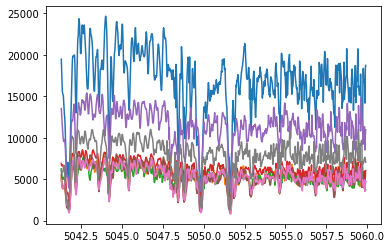

In [22]:
import matplotlib.pyplot as plt 
wl = pd.read_csv("interpolated_wl.csv").to_numpy().T[0]
j = 0
for i in ID_and_flux.to_numpy().T:
    plt.plot(wl[100:1000],i[100:1000])
    if j == 800:
        break
    else:
        j+=1
plt.show()

In [58]:
for i in cirObject.Ivar:
    if not np.isnan(cirObject.Ivar[i]).any(): #Happens in the ivar
            pass
    else:
        print(f"****{i} HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES") 

****r20120306.119 HAS BEEN REMOVED BECAUSE IT CONTAINS NAN VALUES


In [31]:
import numpy as np
import alphashape
from descartes import PolygonPatch
from astropy.io import fits
import matplotlib.pyplot as plt
from localreg import *
from astropy.io import fits

In [32]:
import pandas as pd
import numpy as np

In [70]:
t = pd.read_csv("HIRES_Filename_rv.csv")

In [72]:
t.keys()

dict_keys(['HIRESName', 'FILENAME', 'RV'])

In [25]:
t = np.load('Normalized_Spectra/r20070426.143_specnorm.npy')

In [30]:
t.flatten().shape

(64336,)

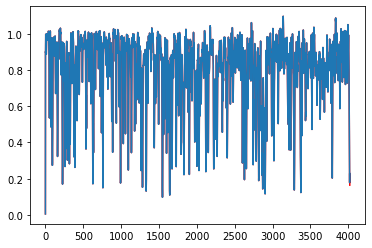

In [37]:
plt.plot(t[0],'r')
plt.plot(t.flatten()[:4020])
plt.show()

In [43]:
(t[1] == t.flatten()[4021:8042]).all()

True

In [67]:
hires = np.genfromtxt("HIRES_Filename_rv.csv",delimiter=',',usecols=(0),skip_header=1,dtype='str')
file = np.genfromtxt("HIRES_Filename_rv.csv",delimiter=',',usecols=(1),skip_header=1,dtype='str')
rv = np.genfromtxt("HIRES_Filename_rv.csv",delimiter=',',usecols=(2),skip_header=1)
filename_rv_df = pd.DataFrame({"HIRESName":hires,'FILENAME':file,"RV":rv})
download_Location = cirObject.dataSpectra.localdir #This is the second parameter of hiresprv.download.Download
spectraDic = {}
for filename in filename_rv_df["FILENAME"]:
    #I tried to use the , seperation and new line seperation 
    #for the different file names but it doesn't seem to work.
    #Thus, a for-loop was used!
    #self.dataSpectra.spectrum(filename.replace("r",""))  #Download spectra 
    file_path = "{0}/{1}.fits".format(download_Location,filename)
    try:
        temp_deblazedFlux = fits.getdata(file_path)
        temp_deblazedFlux = temp_deblazedFlux.flatten()
    except OSError:
        print(filename)

r20150208.120
